# Final Project 
* Hallym Univ. 인공지능개론 최종 과제용 파일입니다
* 제출/발표: 2018/6/22 금 12:30 발표
* 조원 1 / 조원 2 / 조원 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.python.framework import ops
from dd_nnutil_hallym2 import *
import random
import time

ImportError: ignored

### Dataset 업로드 확인

In [0]:
folder1="./dataset2"

In [0]:
import os
sorted(os.listdir(folder1))

['0', '1', '2', '3', '4', '5']

예상되는 출력:

---

['0', '1', '2', '3', '4', '5']

---

위와 다르게 출력이 된다면 애초에 상위 폴더이름이 dataset1 인지 확인해보세요. 


### Data 검토해보기

Data의 종류. 현재는 6가지의 data를 사용하므로 6을 사용합니다.

In [0]:
nclasses = 6

그려볼 이미지 index. 아래의 숫자를 바꾸어 가며 아래 cell에 그림이 제대로 표시가 되는지 확인해보세요.
**최종적으로는 직접 생성한 이미지가 display되도록 idx를 설정하세요**

In [0]:
idx= 152

('class', 0, '--', 200)
('class', 1, '--', 200)
('class', 2, '--', 200)
('class', 3, '--', 200)
('class', 4, '--', 200)
('class', 5, '--', 200)


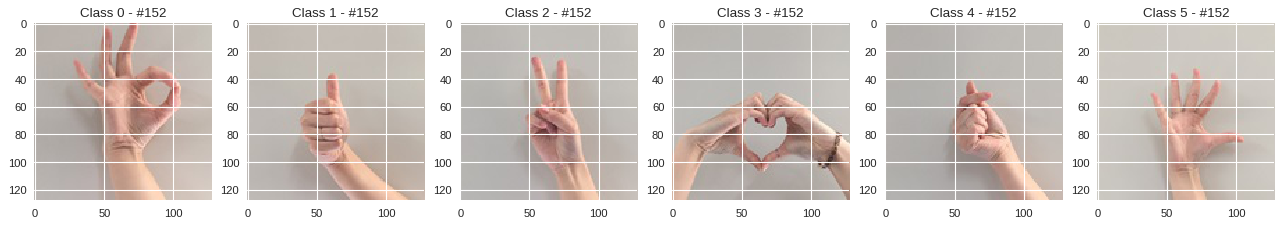

In [0]:
fig, ax = plt.subplots(figsize=(20, 10), dpi=80)
for i in range(nclasses):
    img1, ntot = load_image_test(folder=folder1, img_class=i, idx=idx)
    print('class', i, '--', ntot)
    img1c = centered_crop(img1, output_side_length=128)
    plt.subplot(1,nclasses,i+1)
    plt.title('Class {} - #{}'.format(i, idx))
    plt.imshow(img1c)

### Hyper-parameters

In [0]:
learning_rate=0.01
num_epochs=50
minibatch_size=64

### 본격적으로 시작 - Data 로드 하기

In [0]:
X_train, Y_train_orig, X_test, Y_test_orig = \
    load_dataset(folder=folder1, nclasses=nclasses)

('./dataset2/0/*.JPG', '-->', 200)
('./dataset2/1/*.JPG', '-->', 200)
('./dataset2/2/*.JPG', '-->', 200)
('./dataset2/3/*.JPG', '-->', 200)
('./dataset2/4/*.JPG', '-->', 200)
('./dataset2/5/*.JPG', '-->', 200)


일반 숫자를 one-hot encoding으로 !

In [0]:
Y_train = convert_to_one_hot(Y_train_orig, nclasses).T
Y_test = convert_to_one_hot(Y_test_orig, nclasses).T

Data shape 살펴보기. Dimension을 살펴보세요

In [0]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 840
number of test examples = 360
X_train shape: (840, 128, 128, 3)
Y_train shape: (840, 6)
X_test shape: (360, 128, 128, 3)
Y_test shape: (360, 6)


Text(0.5,1,u'idx #250-- class #[0. 1. 0. 0. 0. 0.]')

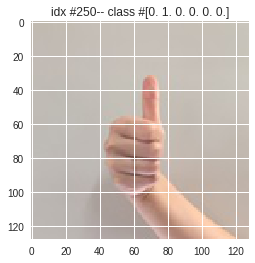

In [0]:
# display images
idx1 = 250
x1 = X_train[idx1]
y1 = Y_train[idx1]

plt.figure()
plt.imshow(x1)
plt.title('idx #{}-- class #{}'.format(idx1, y1))

위의 idx1 값을 바꾸어보며 테스트해보세요.  **마찬가지로 본인들의 사진이 나오도록 최종 idx1 값을 설정하세요**

### Placeholders 만들기

In [0]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])

    return X, Y

### Parameter 초기화 하기
* W1, W2의 크기, 갯수를 원하는 대로 변경하세요. 
* W3, W4.. 등이 필요한 경우 자유롭게 넣어보세요

In [0]:
def initialize_parameters():
    W1 = tf.get_variable("W1", [4, 4, 3, 4], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2, 2, 4, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    #W3 = ...  #필요하면 추가해보세요
    parameters = {"W1": W1,
                  "W2": W2}

    return parameters

### Forward propagation
* 아래는 다음과 같은 ConvNet을 구현한 것입니다. 자유롭게 stride, pooling의 ksize 변경해보세요.
```
CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FC
```
* CONV2D -> RELU -> MAXPOOL 을 하나의 덩어리로 생각하면 좋습니다



In [0]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding='SAME')

    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')

    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None"
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)
    Y_hat = Z3
   
    return Y_hat

### Cost 계산하기

In [0]:
def compute_cost(Y_hat, Y):
     # cost = tf.nn.softmax_cross_entropy_with_logits(logits = Y_hat, labels = Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Y_hat, labels=Y))
    return cost

### Model 
지금까지 함수로 만들었던 기능들을 불러 만들어 네트워크를 구성합니다

In [0]:
(m, n_H0, n_W0, n_C0) = X_train.shape
n_y = Y_train.shape[1]

In [0]:
ops.reset_default_graph()
X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
parameters = initialize_parameters()
Y_hat = forward_propagation(X, parameters)
cost = compute_cost(Y_hat, Y)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

### Start the session to compute the tensorflow graph

In [0]:
print_cost = True

In [0]:
vcosts = []  # cost를 저장할 빈 list
vtime = [] # 연산시간을 기록할 빈 list

In [0]:
# Reset the graph
#tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [0]:
seed = 0
sess.run(tf.global_variables_initializer())
# Do the training loop
for epoch in range(num_epochs):

    minibatch_cost = 0.
    num_minibatches = int(m / minibatch_size)  # number of minibatches of size minibatch_size in the train set
    seed = seed + 1
    minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed=seed)

    for minibatch in minibatches:
        # Select a minibatch
        (minibatch_X, minibatch_Y) = minibatch
        # IMPORTANT: The line that runs the graph on a minibatch.
        # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).

        #_, temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
        t0 = time.time()
        sess.run(optimizer, feed_dict={X: minibatch_X, Y: minibatch_Y})
        t_elapsed = time.time() - t0
        vtime.append(t_elapsed) # 시간을 측정하고 이를 list에 저장함 (append)

        temp_cost = sess.run(cost, feed_dict={X: minibatch_X, Y: minibatch_Y})

        minibatch_cost += temp_cost / num_minibatches

    # Print the cost every epoch
    if print_cost == True and epoch % 5 == 0:
        print("Cost after epoch %i: %f" % (epoch, minibatch_cost))

    vcosts.append(minibatch_cost)

Cost after epoch 0: 1.964867
Cost after epoch 5: 0.200628
Cost after epoch 10: 0.038795
Cost after epoch 15: 0.009473
Cost after epoch 20: 0.003494
Cost after epoch 25: 0.002431
Cost after epoch 30: 0.002776
Cost after epoch 35: 0.001060
Cost after epoch 40: 0.000642
Cost after epoch 45: 0.000521


In [0]:
correct_prediction = tf.equal(tf.argmax(Y_hat, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

print("Mean time to train for each batch: {:.3f} sec / batch size : {}".format(np.mean(vtime), minibatch_size))


('Train Accuracy:', 1.0)
('Test Accuracy:', 0.88055557)
Mean time to train for each batch: 0.545 sec / batch size : 64


학습된 모델로 예측해보기 (correct predictions)
* 10개 테스트 해보기 --> 자유롭게 원하는 대로 변경하여 테스트 해보세요

In [0]:
ntest = 10 

#94, Label: [1], Prediction: [4], [False], Time : 0.010 sec
#355, Label: [5], Prediction: [5], [ True], Time : 0.010 sec
#73, Label: [1], Prediction: [1], [ True], Time : 0.011 sec
#9, Label: [0], Prediction: [0], [ True], Time : 0.011 sec
#334, Label: [5], Prediction: [5], [ True], Time : 0.011 sec
#194, Label: [3], Prediction: [3], [ True], Time : 0.011 sec
#196, Label: [3], Prediction: [3], [ True], Time : 0.011 sec
#11, Label: [0], Prediction: [0], [ True], Time : 0.011 sec
#54, Label: [0], Prediction: [0], [ True], Time : 0.011 sec
#177, Label: [2], Prediction: [5], [False], Time : 0.017 sec


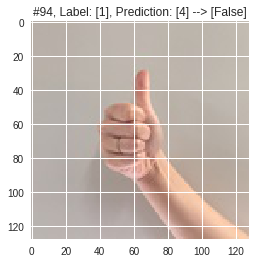

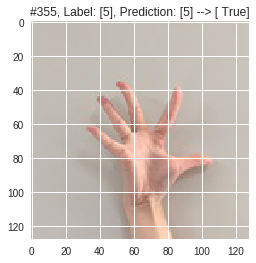

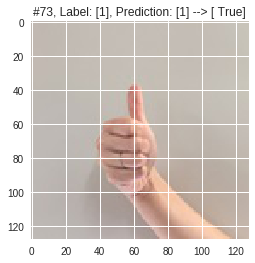

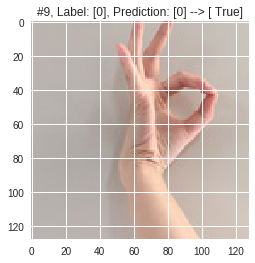

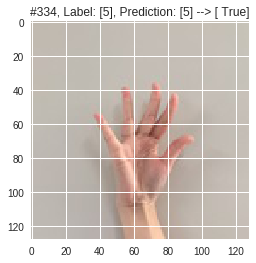

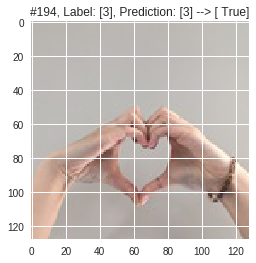

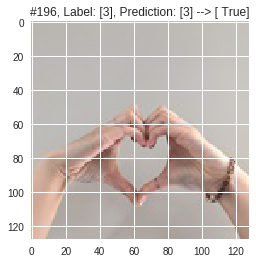

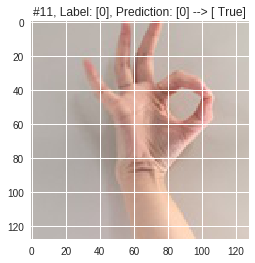

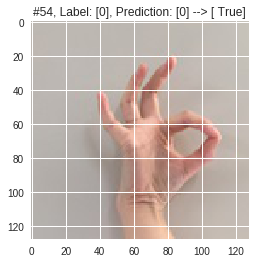

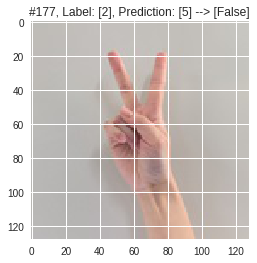

In [0]:
for j in range(0,ntest):
    # Get one and predict
    r = random.randint(0, X_test.shape[0] - 1)
    #print('Picked {} / {}'.format(r, X_test.shape[0]))

    v1 = sess.run(tf.argmax(Y_test[r:r+1], 1))
    t0 = time.time()
    v2 = sess.run(tf.argmax(Y_hat, 1), feed_dict={X: X_test[r:r+1]})
    t_elapsed = time.time() - t0
    bok = v1 == v2
    str1 = '#{}, Label: {}, Prediction: {}, {}, Time : {:.3f} sec'.format(r, v1, v2,bok, t_elapsed)
    print(str1)
    str2 = '#{}, Label: {}, Prediction: {} --> {}'.format(r, v1, v2, bok)
    plt.figure()
    plt.imshow(X_test[r])
    plt.title(str2)


sess.close()

###  Cost 그려보기

Text(0.5,1,u'Learning rate =0.01')

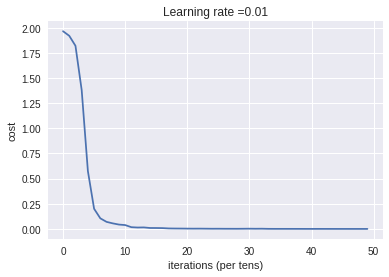

In [0]:
plt.figure()
plt.plot(np.squeeze(vcosts))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(learning_rate))

Cost 의 초반부 확대해서 그려보기

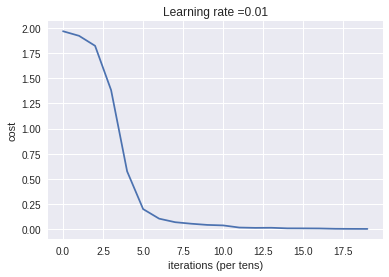

In [0]:
plt.figure()
plt.plot(np.squeeze(vcosts[:20]))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()